<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Advanced_Rag_using_Llama_Index_Querypipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building an “advanced RAG” consisting of query rewriting/retrieval/reranking/synthesis

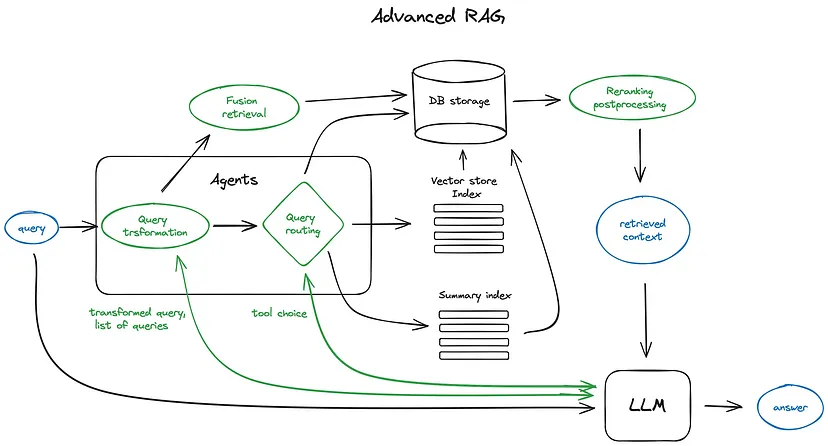

## QueryPipeline
QueryPipeline provides a declarative query orchestration abstraction.
We can use it to compose both sequential chains and directed acyclic graphs (DAGs) of arbitrary complex

It has the following benefits:

* **Express common query workflows with fewer lines of code/boilerplate:** Stop writing converter logic between outputs/inputs, and figuring out the exact typing of arguments for each module!

* **Greater readability:** Reduced boilerplate leads to greater readability.

* **End-to-end observability:** Get callback integration across the entire pipeline (even for arbitrarily nested DAGs), so you stop fiddling around with our observability integrations.

* **[In the future] Easy Serializability:** A declarative interface allows the core components to be serialized/redeployed on other systems much more easily.

* **[In the future] Caching:** This interface also allows us to build a caching layer under the hood, allowing input re-use.

#### Install required Dependencies

In [1]:
!pip install -qU llama-index llama-cpp-python pypdf sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 57.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.4 MB/s eta 0:00:00
ERROR: pip's

In [2]:
!pip install rank-bm25

## Import Required Dependencies

In [ ]:
from llama_index.postprocessor import SentenceTransformerRerank
from llama_index.response_synthesizers import TreeSummarize
from llama_index import ServiceContext
from llama_index.query_pipeline import QueryPipeline

## Setup the embedding model

In [3]:
from llama_index.embeddings import resolve_embed_model
embed_model = resolve_embed_model("local:BAAI/bge-large-en-v1.5")

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## Download open source LLM

In [4]:
! huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False


Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf to /root/.cache/huggingface/hub/tmpg3aw6la8
mistral-7b-instruct-v0.2.Q4_K_M.gguf: 100% 4.37G/4.37G [00:26<00:00, 166MB/s] 
./mistral-7b-instruct-v0.2.Q4_K_M.gguf


## Instantiate the LLM

In [5]:
import os
from llama_index.llms import LlamaCPP
from llama_index.llms.llama_utils import (
    messages_to_prompt,
    completion_to_prompt,
)
llm = LlamaCPP(
    # You can pass in the URL to a GGML model to download it automatically
    #model_url=model_url,
    # optionally, you can set the path to a pre-downloaded model instead of model_url
    model_path=r"/content/mistral-7b-instruct-v0.2.Q4_K_M.gguf",
    temperature=0.1,
    max_new_tokens=256,
    # llama2 has a context window of 4096 tokens, but we set it lower to allow for some wiggle room
    context_window=8000,
    # kwargs to pass to __call__()
    generate_kwargs={},
    # kwargs to pass to __init__()
    # set to at least 1 to use GPU
    model_kwargs={"n_gpu_layers": 0,"n_threads": int(os.cpu_count() /2)},
    # transform inputs into Llama2 format
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    verbose=True,
)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
Model metadata: {'tokenizer.chat_template': "{{ bos_token }}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if message['role'] == 'user' %}{{ '[INST] ' + message['content'] + ' [/INST]' }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token}}{% else %}{{ raise_exception('Only user and assistant roles are supported!') }}{% endif %}{% endfor %}", 'tokenizer.ggml.add_eos_token': 'false', 'tokenizer.ggml.padding_token_id': '0', 'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.eos_token_id': '2', 'general.architecture': 'llama', 'llama.rope.freq_base': '1000000.000000', 'llama.context_length': '32768', 'general.na

In [6]:
int(os.cpu_count() /2)

4

## Load the dataset

In [7]:
!mkdir Data

In [8]:
!wget "https://content.accion.org/wp-content/uploads/2018/08/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf" -P "/content/Data/esops.pdf"

--2024-02-04 12:02:24--  https://content.accion.org/wp-content/uploads/2018/08/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf
Resolving content.accion.org (content.accion.org)... 151.101.194.159
Connecting to content.accion.org (content.accion.org)|151.101.194.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724217 (707K) [application/pdf]
Saving to: ‘/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf’

Employee-Stock-Opti 100%[===================>] 707.24K  --.-KB/s    in 0.04s   

2024-02-04 12:02:24 (15.7 MB/s) - ‘/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf’ saved [724217/724217]



In [9]:
from llama_index import SimpleDirectoryReader
document = SimpleDirectoryReader("/content/Data/esops.pdf").load_data()

In [10]:
print(len(document))

44


In [11]:
document[0]

Document(id_='34f7c5cf-4f9d-4434-bf93-8d980f83035a', embedding=None, metadata={'page_label': '1', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_type': 'application/pdf', 'file_size': 724217, 'creation_date': '2024-02-04', 'last_modified_date': '2018-08-29', 'last_accessed_date': '2024-02-04'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices  \n', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')

In [12]:
document[0].text

'Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices  \n'

In [13]:
document[0].metadata

{'page_label': '1',
 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
 'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
 'file_type': 'application/pdf',
 'file_size': 724217,
 'creation_date': '2024-02-04',
 'last_modified_date': '2018-08-29',
 'last_accessed_date': '2024-02-04'}

## SimpleNodeParser
SimpleNodeParser converts documents into a list of nodes. It offers flexibility in how the document is parsed, allowing for customization in terms of chunk size, overlap, and inclusion of metadata.

##  SentenceSplitter
The SentenceSplitter is a type of text splitter that breaks down the text into sentences.

This is useful when you want to maintain the integrity of individual sentences within each chunk.

In [14]:
from llama_index.text_splitter import SentenceSplitter
from llama_index.node_parser import SimpleNodeParser

#
node_parser = SimpleNodeParser.from_defaults(paragraph_separator=r"\n●|\n-|\n",
                                             chunk_size=250,
                                             chunk_overlap=25,
                                              include_prev_next_rel=True,
                                              include_metadata=True
                                              )
split_nodes = node_parser.get_nodes_from_documents(document)

In [15]:
len(split_nodes)

53

In [ ]:
split_nodes[1].text

'Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5.'

In [16]:
split_nodes[1].metadata


{'page_label': '2',
 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
 'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
 'file_type': 'application/pdf',
 'file_size': 724217,
 'creation_date': '2024-02-04',
 'last_modified_date': '2018-08-29',
 'last_accessed_date': '2024-02-04'}

## SentenceWindowNodeParser
The SentenceWindowNodeParser class is designed to parse documents into nodes (sentences) and capture a window of surrounding sentences for each node.

In [17]:
from llama_index.node_parser import SentenceWindowNodeParser
from typing import List
import re
def custom_sentence_splitter(text: str) -> List[str]:
    return re.split(r'\n●|\n-|\n', text)
swindow_node_parser = SentenceWindowNodeParser.from_defaults(
    sentence_splitter=custom_sentence_splitter,
    window_size=3,
    include_prev_next_rel=True,
    include_metadata=True
    )

##  Processing Nodes

For each base node, it generates sub-nodes using the SentenceWindowNodeParser (with custom settings). Then, it converts the base nodes and their corresponding sub-nodes into IndexNode instances.

The final list of IndexNode instances is stored in all_nodes.

An IndexNode is a node object used in LlamaIndex.
At its core, the IndexNode inherits properties from a TextNode, meaning it primarily represents textual content.

In [18]:
from llama_index.schema import IndexNode
sub_node_parsers =[swindow_node_parser]
all_nodes = []
for base_node in split_nodes:
    for parser in sub_node_parsers:
        sub_nodes = parser.get_nodes_from_documents([base_node])
        sub_inodes = [
            IndexNode.from_text_node(sn, base_node.node_id) for sn in sub_nodes
        ]
        all_nodes.extend(sub_inodes)
    # also add original node to node
    original_node = IndexNode.from_text_node(base_node, base_node.node_id)
    all_nodes.append(original_node)

In [19]:
len(all_nodes)

642

In [20]:
all_nodes[10].relationships

{<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a34abb69-28a7-4445-a4ae-11bb62b9d3f2', node_type=<ObjectType.TEXT: '1'>, metadata={'page_label': '2', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_type': 'application/pdf', 'file_size': 724217, 'creation_date': '2024-02-04', 'last_modified_date': '2018-08-29', 'last_accessed_date': '2024-02-04'}, hash='11d9d446c4749d9fbac8b64b0d840a34a493e875c868faf04ce0e83ed12151fc'),
 <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='bde7b997-c4f9-4610-a5f3-2ba88fa3532b', node_type=<ObjectType.TEXT: '1'>, metadata={'window': 'Part I: Intro to Options Plans   •What is an ESOP?   •What is an Option?   •Lifecycle of a Startup ESOP   •Common Terms in an Options Package   •Why Issue Options to Employees ? ', 'original_text': '•Lifecycle of a Startup ESOP  ', 'page_label': '2', 'file_name': 'Employee-Stock-Option-Plan

In [21]:
all_nodes[10].text

'•Common Terms in an Options Package  '

In [22]:
all_nodes[10].metadata

{'window': '•What is an ESOP?   •What is an Option?   •Lifecycle of a Startup ESOP   •Common Terms in an Options Package   •Why Issue Options to Employees ?  –A Defining Characteristic of Startup Culture  ',
 'original_text': '•Common Terms in an Options Package  ',
 'page_label': '2',
 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
 'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
 'file_type': 'application/pdf',
 'file_size': 724217,
 'creation_date': '2024-02-04',
 'last_modified_date': '2018-08-29',
 'last_accessed_date': '2024-02-04'}

In [23]:
all_nodes_dict = {n.node_id: n for n in all_nodes}

## Instantiate the ServiceContext


The ServiceContext in LlamaIndex is a utility container that bundles commonly used resources during the indexing and querying stages of a LlamaIndex pipeline or application

In [27]:
from llama_index import ServiceContext
service_context = ServiceContext.from_defaults(llm=llm,embed_model=embed_model)

## Instantiate the  VectorStoreIndex
A VectorStoreIndex in LlamaIndex is a type of index that uses vector representations of text for efficient retrieval of relevant context.

In [28]:
from llama_index import VectorStoreIndex
vector_index_chunk = VectorStoreIndex(
    all_nodes, service_context=service_context
)

## Instantiate Longcontext Retriever

In [29]:
from llama_index.postprocessor import LongContextReorder
lim_reorder = LongContextReorder()

In [30]:
type(lim_reorder)

llama_index.postprocessor.node.LongContextReorder

## Instantiate RecursiveRetriever

The RecursiveRetriever is designed to recursively explore links from nodes to other retrievers or query engines.

This means that when the retriever fetches nodes, if any of those nodes point to another retriever or query engine, the RecursiveRetriever will follow that link and query the linked retriever or engine as well.

In [31]:
from llama_index.retrievers import RecursiveRetriever
vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=5)
retriever_chunk = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk,"long_context":lim_reorder},
    node_dict=all_nodes_dict,
    verbose=True,
)

In [32]:
type(vector_retriever_chunk)

llama_index.indices.vector_store.retrievers.retriever.VectorIndexRetriever

In [33]:
vector_index_chunk.set_index_id("vector_index")
vector_index_chunk.storage_context.persist("./storage")

In [ ]:
retriever_chunk.retrieve("What is esops?")

Retrieving with query id None: What is esops?
Retrieved node with id, entering: 3e6e0383-528f-4852-abe3-e5904dea85a9
Retrieving with query id 3e6e0383-528f-4852-abe3-e5904dea85a9: What is esops?
Retrieved node with id, entering: 3cf8dd05-8e94-4bbb-95fa-3079771c9a8c
Retrieving with query id 3cf8dd05-8e94-4bbb-95fa-3079771c9a8c: What is esops?
Retrieved node with id, entering: f7ee3c2b-566b-4c37-801b-a30d1430bce8
Retrieving with query id f7ee3c2b-566b-4c37-801b-a30d1430bce8: What is esops?


[NodeWithScore(node=IndexNode(id_='3e6e0383-528f-4852-abe3-e5904dea85a9', embedding=None, metadata={'page_label': '4', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_type': 'application/pdf', 'file_size': 724217, 'creation_date': '2024-02-04', 'last_modified_date': '2018-08-29', 'last_accessed_date': '2024-02-04'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='124bdbe8-5a38-41b4-8393-c1b49e695541', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '4', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path': '/content/Data/esops.pdf/Employee-Stock

#### Rebuild index
```
# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir="storage")
# load index
index = load_index_from_storage(storage_context, index_id="vector_index")

```

## Instantiate the Reranker

In [34]:
import torch
from llama_index.postprocessor import SentenceTransformerRerank
reranker = SentenceTransformerRerank(model="cross-encoder/ms-marco-MiniLM-L-2-v2",
                                     top_n=5)

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [35]:
type(reranker)

llama_index.postprocessor.sbert_rerank.SentenceTransformerRerank

## Hybrid Fusion Retriever

In [36]:
from llama_index.retrievers import BM25Retriever
bm25_retriever = BM25Retriever.from_defaults(docstore=vector_index_chunk.docstore, similarity_top_k=5)

/usr/local/lib/python3.10/dist-packages/llama_index/indices/keyword_table/utils.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts = pd.Series(tokens).value_counts()
/usr/local/lib/python3.10/dist-packages/llama_index/indices/keyword_table/utils.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts = pd.Series(tokens).value_counts()
/usr/local/lib/python3.10/dist-packages/llama_index/indices/keyword_table/utils.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts = pd.Series(tokens).value_counts()
/usr/local/lib/python3.10/dist-packages/llama_index/indices/keyword_table/utils.py:19: FutureWarning: The 

In [37]:
from llama_index.retrievers import QueryFusionRetriever
hybrid_retriever = QueryFusionRetriever(
    [vector_retriever_chunk, bm25_retriever],
    llm=llm,
    similarity_top_k=3,
    num_queries=4,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=True,
    verbose=True,
    # query_gen_prompt="...",  # we could override the query generation prompt here
)

In [38]:
type(hybrid_retriever)

llama_index.retrievers.fusion_retriever.QueryFusionRetriever

## Define the Prompt


In [39]:
from llama_index.prompts import PromptTemplate
prompt_str = "Please generate a concise question about {question}"
prompt_tmpl = PromptTemplate(prompt_str)

In [40]:
from llama_index.query_engine import RetrieverQueryEngine
query_engine_chunk = RetrieverQueryEngine.from_args(
    retriever_chunk,
    service_context=service_context,
    verbose=True,
    response_mode="compact",
    node_postprocessors=[LongContextReorder(),reranker]
    )

In [ ]:
response = query_engine_chunk.query(
   "What is Esops?"
)
print(str(response))

Retrieving with query id None: What is Esops?
Retrieved node with id, entering: 3e6e0383-528f-4852-abe3-e5904dea85a9
Retrieving with query id 3e6e0383-528f-4852-abe3-e5904dea85a9: What is Esops?
Retrieved node with id, entering: 3cf8dd05-8e94-4bbb-95fa-3079771c9a8c
Retrieving with query id 3cf8dd05-8e94-4bbb-95fa-3079771c9a8c: What is Esops?
Retrieved node with id, entering: f7ee3c2b-566b-4c37-801b-a30d1430bce8
Retrieving with query id f7ee3c2b-566b-4c37-801b-a30d1430bce8: What is Esops?
 An ESOP, or Employee Stock Option Plan, is a plan that allocates shares to employees in the form of stock options. The plan includes details on how these options will be distributed, such as the number of shares each employee will receive and the terms governing the grants. The ESOP is an important aspect of the allocation of equity to employees in a company.


## Implementing a RAG query pipeline using Query Rewriting,SentenceWindowNodeParser, Longontext Retriver,hybrid search,Reranker and Summarizer

```q = QueryPipeline(
    reader=SimpleDirectoryReader('data/meteoric'),
    splitter=CharacterTextSplitter(chunk_overlap=40, chunk_size=1024),
    openai_embeddings=OpenAIEmbeddings(),
    postprocessor=TreeSummarize(),
    query_bundle={"query_str": "What is ESOPs?"}
)
```

In [41]:
query_engine_chunk = RetrieverQueryEngine.from_args(
    hybrid_retriever,
    service_context=service_context,
    verbose=True,
    response_mode="compact",
    node_postprocessors=[LongContextReorder(),reranker]
    )

In [42]:
type(query_engine_chunk)

llama_index.query_engine.retriever_query_engine.RetrieverQueryEngine

In [44]:
from llama_index.query_pipeline.query import QueryPipeline
q = QueryPipeline(chain=[prompt_tmpl,llm,retriever_chunk,query_engine_chunk],verbose=True)

In [47]:
q.run(question="What is ESOPs?")

> Running module 7ef1f981-ba78-458a-8de0-35567e1b9a79 with input: 
question: What is ESOPs?

> Running module b94523f8-26f3-44d7-8ef5-cdd08436eb22 with input: 
prompt: Please generate a concise question about What is ESOPs?



Llama.generate: prefix-match hit


> Running module 183049be-a37d-4c51-b824-11beb242933d with input: 
input:  What are Employee Stock Ownership Plans (ESOPs) and how do they function?

Retrieving with query id None:  What are Employee Stock Ownership Plans (ESOPs) and how do they function?
Retrieved node with id, entering: 82dcddb6-55e1-43fc-b1c2-0460460bae61
Retrieving with query id 82dcddb6-55e1-43fc-b1c2-0460460bae61:  What are Employee Stock Ownership Plans (ESOPs) and how do they function?
Retrieved node with id, entering: 8e157341-eb5d-40b6-97e7-8b03c320b0c1
Retrieving with query id 8e157341-eb5d-40b6-97e7-8b03c320b0c1:  What are Employee Stock Ownership Plans (ESOPs) and how do they function?
Retrieved node with id, entering: a64f70f9-1ce3-4091-b031-bf5c9a83ef43
Retrieving with query id a64f70f9-1ce3-4091-b031-bf5c9a83ef43:  What are Employee Stock Ownership Plans (ESOPs) and how do they function?
Retrieved node with id, entering: dac95671-01d8-4b83-8263-4eae8453615f
Retrieving with query id dac95671-01d8-4b83-82

Llama.generate: prefix-match hit


Generated queries:
 1. "How is equity allocated to employees in an ESOP?"
2. "What is the difference between Silicon Valley companies and other industries in terms of equity distribution to employees?"
3. "What is the process for deciding the amount of equity to be granted to employees in an ESOP?"


Llama.generate: prefix-match hit


Response(response=' An Employee Stock Options Plan (ESOP) is a plan that allocates shares of a company that will be granted to employees in the future in the form of stock options. There are two approaches to creating an ESOP: top-down and bottom-up planning. Top-down planning involves deciding the total amount of equity to be granted to employees and allocating these shares to them over time. Bottom-up planning, on the other hand, specifically considers how much equity each employee should be awarded based on their position and uses this framework for individual equity grants. The goal is to get away from ad hoc equity awards and personal negotiations by standardizing both the amount of equity available to employees and the process by which packages are awarded. This practice is widely used in Silicon Valley companies and is a defining characteristic of startup culture.', source_nodes=[NodeWithScore(node=IndexNode(id_='a64f70f9-1ce3-4091-b031-bf5c9a83ef43', embedding=None, metadata={'

In [46]:
# apply nested async to run in a notebook
import nest_asyncio
nest_asyncio.apply()
#
nodes_with_scores = hybrid_retriever.retrieve("What is Esops?")

Llama.generate: prefix-match hit


Generated queries:
 1. "What is the meaning of ESOPs in business?"
2. "Explanation of Employee Stock Ownership Plans (ESOPs)"
3. "How do Employee Stock Ownership Plans (ESOPs) work?"


In [49]:
for node in nodes_with_scores:
    print(f"Text:{node.text}")
    print(f"Score:{node.score}")
    print(f"Metadata:{node.metadata}")
    print("\n\n")

Text:What is an ESOP?  
•An Employee Stock Options Plan (ESOP)  
 
•An allocation  of shares that will be granted to employees in the future 
in the form of stock options  
–How much equity should we set aside for employees?  
 
•A plan for how these options will be distributed:  
–How many shares will individual employees receive?  
–What terms will govern these grants?  
 
•The plan is as important as the allocation!
Score:0.05
Metadata:{'page_label': '4', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_type': 'application/pdf', 'file_size': 724217, 'creation_date': '2024-02-04', 'last_modified_date': '2018-08-29', 'last_accessed_date': '2024-02-04'}



Text:•An Employee Stock Options Plan (ESOP)  
Score:0.03333333333333333
Metadata:{'window': 'What is an ESOP?   •An Employee Stock Options Plan (ESOP)     •An allocation  of shares that will be granted to employees

In [ ]:
#
query_engine_chunk = RetrieverQueryEngine.from_args(
    hybrid_retriever,
    service_context=service_context,
    verbose=True,
    response_mode="compact",
    node_postprocessors=[LongContextReorder(),reranker]
    )


In [ ]:
output =query_engine_chunk.query("What is ESOPs?")

Llama.generate: prefix-match hit


Generated queries:
 1. "Definition of ESOPs: What are Employee Stock Ownership Plans?"
2. "How do Employee Stock Ownership Plans (ESOPs) work?"
3. "Benefits and disadvantages of Employee Stock Ownership Plans (ESOPs)"


Llama.generate: prefix-match hit


In [ ]:
print(str(output))

 An Employee Stock Options Plan (ESOP) is a plan through which a company grants its employees the option to purchase a certain number of shares of the company's stock in the future at a predetermined price, called the exercise price. The specifics of the plan, such as the allocation of shares to be set aside for employees and the terms governing the grants, are important considerations in the implementation of an ESOP.


####v Method -2 creating a RAG DAG

In [ ]:
pipe = QueryPipeline(verbose=True)
pipe.add_modules({"prompt_tmpl":prompt_tmpl,
               "llm":llm,
               "retriever":retriever_chunk,
               "reranker":reranker,
               "query_engine":query_engine_chunk})

In [ ]:
llm.as_query_component().input_keys,llm.as_query_component().output_keys

(InputKeys(required_keys={'prompt'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
prompt_tmpl.as_query_component().input_keys,prompt_tmpl.as_query_component().output_keys

(InputKeys(required_keys={'question'}, optional_keys=set()),
 OutputKeys(required_keys={'prompt'}))

In [ ]:
retriever_chunk.as_query_component().input_keys,retriever_chunk.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
reranker.as_query_component().input_keys,reranker.as_query_component().output_keys

(InputKeys(required_keys={'nodes'}, optional_keys={'query_str'}),
 OutputKeys(required_keys={'nodes'}))

In [ ]:
query_engine_chunk.as_query_component().input_keys,query_engine_chunk.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
pipe.add_link("prompt_tmpl", "llm")
pipe.add_link("llm", "retriever")
pipe.add_link("retriever", "reranker",dest_key="nodes")
pipe.add_link("llm", "reranker",dest_key="query_str")
pipe.add_link("reranker", "query_engine")


In [53]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00


In [ ]:
## create graph
from pyvis.network import Network

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(pipe.dag)
net.save_graph("rag_dag.html")

In [ ]:
from IPython.display import HTML, display
HTML(filename="rag_dag.html")

In [ ]:
response = pipe.run("what is esops ?")

> Running module prompt_tmpl with input: 
question: what is esops ?

> Running module llm with input: 
prompt: Please provide a brief answer to the question what is esops ?



Llama.generate: prefix-match hit


> Running module retriever with input: 
input:  ESOP stands for Employee Stock Ownership Plan. It is a retirement plan that enables employees to own company stocks. The company contributes its own shares to the trust on behalf of the employees, wh...

Retrieving with query id None:  ESOP stands for Employee Stock Ownership Plan. It is a retirement plan that enables employees to own company stocks. The company contributes its own shares to the trust on behalf of the employees, who become beneficiaries of the trust. ESOPs can also allow employees to purchase company stock at a discounted price or through payroll deductions. The ultimate goal of an ESOP is to align the interests of employees with those of the company's owners and to provide employees with an incentive to increase company value through their work.
Retrieved node with id, entering: 3e6e0383-528f-4852-abe3-e5904dea85a9
Retrieving with query id 3e6e0383-528f-4852-abe3-e5904dea85a9:  ESOP stands for Employee Stock Ownership Pl

Llama.generate: prefix-match hit


In [ ]:
print(str(response))

 An option is a right, but not an obligation, to purchase a quantity of a company's stock at a set price for a certain period of time. Startups use options as an effective form of equity ownership and a locked-in price for shares to bring in founding team members who are not co-founders, recruit, compensate, and retain early employees, and allow later employees to share in the company's long-term success. Creating an ESOP requires a combination of top-down and bottom-up planning. Top-down planning involves deciding the total amount of equity to be granted and allocating these shares to employees over time. Bottom-up planning involves deciding the appropriate size of individual equity grants by position and issuing these shares as employees are hired. The ESOP is an allocation of shares that will be granted to employees in the future in the form of stock options. The amount of equity that should be set aside for employees and the terms of the options distribution are important considera

#### RAG without query rewriting

In [50]:
from llama_index.query_pipeline import InputComponent
inputs = InputComponent()
pipe_1 =  QueryPipeline(verbose=True)
pipe_1.add_modules({"input":inputs,
               "retriever":retriever_chunk,
               "query_engine":query_engine_chunk})

In [ ]:
retriever_chunk.as_query_component().input_keys,retriever_chunk.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
query_engine_chunk.as_query_component().input_keys,query_engine_chunk.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
llm.as_query_component().input_keys,llm.as_query_component().output_keys

(InputKeys(required_keys={'prompt'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [51]:
pipe_1.add_link("input", "retriever")
pipe_1.add_link("input", "query_engine")
pipe_1.add_link("retriever", "query_engine")

In [54]:
## create graph
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(pipe_1.dag)
net.save_graph("rag_dag1.html")
#

HTML(filename="rag_dag1.html")

In [57]:
output = pipe_1.run(input="what is esops ?")

> Running module input with input: 
input: what is esops ?

> Running module retriever with input: 
input: what is esops ?

Retrieving with query id None: what is esops ?
Retrieved node with id, entering: 82dcddb6-55e1-43fc-b1c2-0460460bae61
Retrieving with query id 82dcddb6-55e1-43fc-b1c2-0460460bae61: what is esops ?
Retrieved node with id, entering: 6c5ecaf9-09be-4712-a0e9-4807cbcae1bd
Retrieving with query id 6c5ecaf9-09be-4712-a0e9-4807cbcae1bd: what is esops ?
Retrieved node with id, entering: b0e7bf68-fc08-4667-99fb-a638d170fafd
Retrieving with query id b0e7bf68-fc08-4667-99fb-a638d170fafd: what is esops ?
> Running module query_engine with input: 
input: [NodeWithScore(node=IndexNode(id_='82dcddb6-55e1-43fc-b1c2-0460460bae61', embedding=None, metadata={'page_label': '4', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path'...



Llama.generate: prefix-match hit


Generated queries:
 1. "Employee Stock Options Plan (ESOP): How is equity allocated to employees?"
2. "Determining the amount of equity to set aside for ESOP distribution"
3. "ESOP distribution: Calculating the number of shares for individual employees and their terms"


Llama.generate: prefix-match hit


In [58]:
print(str(output))

 An Employee Stock Options Plan (ESOP) is a plan that allocates shares that will be granted to employees in the future in the form of stock options. The company needs to determine how much equity to set aside for employees and create a plan for how these options will be distributed. The distribution plan includes determining how many shares individual employees will receive and what terms will govern these grants.


#### Query Pipeline 2 using Hybrid Retriver,LongContextReorder and Reranker

In [ ]:
inputs = InputComponent()
pipe_2 =  QueryPipeline(verbose=True)
pipe_2.add_modules({"input":inputs,
               "retriever":hybrid_retriever,
               "query_engine":query_engine_chunk})
#

pipe_2.add_link("input", "retriever")
pipe_2.add_link("retriever", "query_engine")


## Visualize DAG

In [ ]:
## create graph
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(pipe_2.dag)
net.save_graph("rag_dag2.html")
#

HTML(filename="rag_dag2.html")

In [ ]:
response = pipe_2.run(input="what is esops ?")

> Running module input with input: 
input: what is esops ?

> Running module retriever with input: 
input: what is esops ?



Llama.generate: prefix-match hit


Generated queries:
 1. "What is the meaning of ESOPs in business?"
2. "Explanation of Employee Stock Ownership Plans (ESOPs)"
3. "How do Employee Stock Ownership Plans (ESOPs) work?"
> Running module query_engine with input: 
input: [NodeWithScore(node=IndexNode(id_='3e6e0383-528f-4852-abe3-e5904dea85a9', embedding=None, metadata={'page_label': '4', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path'...



Llama.generate: prefix-match hit


Generated queries:
 1. "How does an Employee Stock Options Plan (ESOP) work for companies?"
2. "What is the process for distributing shares in an ESOP?"
3. "How is the number of shares determined for individual employees in an ESOP?"


Llama.generate: prefix-match hit


In [ ]:
print(str(response))

 An Employee Stock Options Plan (ESOP) is a plan through which a company sets aside a certain allocation of shares that will be granted to employees in the future in the form of stock options. The company determines how much equity to set aside for non-founder employees and creates a schedule for how this equity will be distributed over time. The number of shares that individual employees will receive is part of the plan for distributing these options.


#### RAG DAG Query Pipeline Involving Query Rewriting

In [ ]:
from llama_index.response_synthesizers import TreeSummarize

summarizer = TreeSummarize(
    service_context=service_context,
   )


# define query pipeline
pipe_3 = QueryPipeline(verbose=True)
pipe_3.add_modules(
    {
        "llm": llm,
        "prompt_tmpl": prompt_tmpl,
        "retriever": retriever_chunk,
        "summarizer": summarizer,
        "reranker": reranker,
    }
)


In [ ]:
llm.as_query_component().input_keys,llm.as_query_component().output_keys

(InputKeys(required_keys={'prompt'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
prompt_tmpl.as_query_component().input_keys,prompt_tmpl.as_query_component().output_keys

(InputKeys(required_keys={'question'}, optional_keys=set()),
 OutputKeys(required_keys={'prompt'}))

In [ ]:
retriever_chunk.as_query_component().input_keys,retriever_chunk.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
reranker.as_query_component().input_keys,reranker.as_query_component().output_keys

(InputKeys(required_keys={'nodes'}, optional_keys={'query_str'}),
 OutputKeys(required_keys={'nodes'}))

In [ ]:
summarizer.as_query_component().input_keys,summarizer.as_query_component().output_keys

(InputKeys(required_keys={'nodes', 'query_str'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
# add edges
pipe_3.add_link("prompt_tmpl", "llm")
pipe_3.add_link("llm", "retriever")
pipe_3.add_link("retriever", "reranker", dest_key="nodes")
pipe_3.add_link("llm", "reranker", dest_key="query_str")
pipe_3.add_link("reranker", "summarizer", dest_key="nodes")
pipe_3.add_link("llm", "summarizer", dest_key="query_str")

#### Visualize Pipeline 3

In [ ]:
## create graph
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(pipe_3.dag)
net.save_graph("rag_dag3.html")
#

HTML(filename="rag_dag3.html")

In [ ]:
output = pipe_3.run(question="What is ESOPs?")

> Running module prompt_tmpl with input: 
question: What is ESOPs?

> Running module llm with input: 
prompt: Please provide a brief answer to the question What is ESOPs?



Llama.generate: prefix-match hit


> Running module retriever with input: 
input:  An Employee Stock Ownership Plan (ESOP) is a retirement plan where participating employees become owners of company stock. ESOPs allow employees to have a stake in the company they work for through t...

Retrieving with query id None:  An Employee Stock Ownership Plan (ESOP) is a retirement plan where participating employees become owners of company stock. ESOPs allow employees to have a stake in the company they work for through the allocation of company stock in their retirement accounts. The company contributes new shares of its own stock to the ESOP trust on behalf of eligible employees. Over time, employees can build up significant equity in the company, which can result in increased job satisfaction, motivation, and potential for long-term financial gains.
Retrieved node with id, entering: 3e6e0383-528f-4852-abe3-e5904dea85a9
Retrieving with query id 3e6e0383-528f-4852-abe3-e5904dea85a9:  An Employee Stock Ownership Plan (ESOP) is a

Llama.generate: prefix-match hit


In [ ]:
print(str(output))

 I'm sorry for the misunderstanding, but the information provided in the query is incorrect. An Employee Stock Ownership Plan (ESOP) is not a retirement plan where participating employees become owners of company stock exclusively for retirement purposes. Instead, it is an allocation of shares that will be granted to employees in the future in the form of stock options. The plan outlines how these options will be distributed, including the number of shares individual employees will receive and the terms governing these grants. The ESOP is designed to provide employees with an ownership stake in the company to increase job satisfaction, motivation, and potential for long-term financial gains when the company is acquired or goes public.


In [ ]:
output.metadata

{'e084f59b-fe5d-4ce0-9b75-b08452642395': {'page_label': '5',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 'e4ea4cb7-da79-4656-ae89-bf342c274295': {'page_label': '6',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 '97ae5ee7-16f6-471a-b09f-f101a329700d': {'page_label': '25',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-B

In [ ]:
type(output.metadata)

dict

In [ ]:
output.metadata.keys()

dict_keys(['e084f59b-fe5d-4ce0-9b75-b08452642395', 'e4ea4cb7-da79-4656-ae89-bf342c274295', '97ae5ee7-16f6-471a-b09f-f101a329700d', '3e6e0383-528f-4852-abe3-e5904dea85a9', 'f08f1387-0c0e-4cb2-8707-438a1d1a5018'])

#### Pipeline 4 - Without Query rewriting

In [ ]:
# define query pipeline
pipe_4 = QueryPipeline(verbose=True)
pipe_4.add_modules(
    {
        "input": inputs,
        "retriever": retriever_chunk,
        "summarizer": summarizer,
        "reranker": reranker,
    }
)

In [ ]:
reranker.as_query_component().input_keys,reranker.as_query_component().output_keys

(InputKeys(required_keys={'nodes'}, optional_keys={'query_str'}),
 OutputKeys(required_keys={'nodes'}))

In [ ]:
summarizer.as_query_component().input_keys,summarizer.as_query_component().output_keys

(InputKeys(required_keys={'nodes', 'query_str'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
retriever_chunk.as_query_component().input_keys,retriever_chunk.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
# add edges
pipe_4.add_link("input", "retriever")
pipe_4.add_link("retriever", "reranker", dest_key="nodes")
pipe_4.add_link("input", "reranker", dest_key="query_str")
pipe_4.add_link("reranker", "summarizer", dest_key="nodes")
pipe_4.add_link("input", "summarizer", dest_key="query_str")

In [ ]:
## create graph
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(pipe_4.dag)
net.save_graph("rag_dag4.html")
#

HTML(filename="rag_dag4.html")

In [ ]:
output = pipe_4.run(question="What is ESOPs?")

> Running module input with input: 
question: What is ESOPs?

> Running module retriever with input: 
input: What is ESOPs?

Retrieving with query id None: What is ESOPs?
Retrieved node with id, entering: 3e6e0383-528f-4852-abe3-e5904dea85a9
Retrieving with query id 3e6e0383-528f-4852-abe3-e5904dea85a9: What is ESOPs?
Retrieved node with id, entering: 3cf8dd05-8e94-4bbb-95fa-3079771c9a8c
Retrieving with query id 3cf8dd05-8e94-4bbb-95fa-3079771c9a8c: What is ESOPs?
Retrieved node with id, entering: f7ee3c2b-566b-4c37-801b-a30d1430bce8
Retrieving with query id f7ee3c2b-566b-4c37-801b-a30d1430bce8: What is ESOPs?
> Running module reranker with input: 
query_str: What is ESOPs?
nodes: [NodeWithScore(node=IndexNode(id_='3e6e0383-528f-4852-abe3-e5904dea85a9', embedding=None, metadata={'page_label': '4', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path'...

> Running module summarizer with input: 
query_str: What is ESOPs?
nodes: [NodeWithScore(node=IndexNode(i

Llama.generate: prefix-match hit


In [ ]:
print(str(output))

 An Employee Stock Option Plan (ESOP) is a plan that allocates shares to employees in the form of stock options. The plan includes details on how these options will be distributed, such as the number of shares each employee will receive and the terms governing the grants. The ESOP is an important aspect of the allocation of equity to employees in a company.


In [ ]:
output.metadata

{'3e6e0383-528f-4852-abe3-e5904dea85a9': {'page_label': '4',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 '3cf8dd05-8e94-4bbb-95fa-3079771c9a8c': {'page_label': '44',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 'f7ee3c2b-566b-4c37-801b-a30d1430bce8': {'page_label': '40',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-

In [ ]:
output = pipe_4.run(question="What is the purpose of using options by startups?")

> Running module input with input: 
question: What is the purpose of using options by startups?

> Running module retriever with input: 
input: What is the purpose of using options by startups?

Retrieving with query id None: What is the purpose of using options by startups?
Retrieved node with id, entering: e084f59b-fe5d-4ce0-9b75-b08452642395
Retrieving with query id e084f59b-fe5d-4ce0-9b75-b08452642395: What is the purpose of using options by startups?
Retrieved node with id, entering: 28ed05bb-863c-4a26-8c8b-2705428d5d18
Retrieving with query id 28ed05bb-863c-4a26-8c8b-2705428d5d18: What is the purpose of using options by startups?
Retrieved node with id, entering: 4c11545c-f2fd-43bb-afc0-1f58a0837547
Retrieving with query id 4c11545c-f2fd-43bb-afc0-1f58a0837547: What is the purpose of using options by startups?
Retrieved node with id, entering: e4ea4cb7-da79-4656-ae89-bf342c274295
Retrieving with query id e4ea4cb7-da79-4656-ae89-bf342c274295: What is the purpose of using options b

Llama.generate: prefix-match hit


In [ ]:
print(str(output))

 Startups use options as an essential element of their culture to align employee compensation with the risk-prone mentality of the business. They distribute meaningful equity, usually in the form of stock options, to ordinary employees to attract talent, retain employees, align incentives, reward value creation, and encourage long-term thinking. This practice helps build the company for long-term success by making employees equity owners and providing them with strong incentives to remain with the company. Options provide employees with a locked-in price for shares, acting as an effective form of equity ownership. Startups issue options to bring in founding team members who are not co-founders, recruit, compensate, and retain early employees, and allow later employees to share in the company's long-term upside. The options vest over several years, and employees can exercise them when the company is acquired or taken public, paying the strike price to acquire the shares at their then-hi

In [ ]:
output.metadata

{'e084f59b-fe5d-4ce0-9b75-b08452642395': {'page_label': '5',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 '28ed05bb-863c-4a26-8c8b-2705428d5d18': {'page_label': '9',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 'e4ea4cb7-da79-4656-ae89-bf342c274295': {'page_label': '6',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Be

#### Pipeline 5 - sparse vector serach , dense vector search , longcontext reorder, reranker, summarizer

In [ ]:
pipe5 = QueryPipeline(chain=[inputs,hybrid_retriever,query_engine_chunk],verbose=True)

In [ ]:
output = pipe5.run(input="What is ESOPs?")

> Running module ad4a248a-867c-4395-acf5-f390a1ad4530 with input: 
input: What is ESOPs?

> Running module 5bca4d12-e3ab-4667-8f43-57ace1006f6e with input: 
input: What is ESOPs?



Llama.generate: prefix-match hit


Generated queries:
 1. "Definition of ESOPs: What does ESOP stand for in business?"
2. "Explanation of Employee Stock Ownership Plans (ESOPs) and their benefits"
3. "How do Employee Stock Ownership Plans (ESOPs) work in companies?"
> Running module 668e41f9-74e5-40b7-8668-79f7720add4f with input: 
input: [NodeWithScore(node=IndexNode(id_='3e6e0383-528f-4852-abe3-e5904dea85a9', embedding=None, metadata={'page_label': '4', 'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'file_path'...



Llama.generate: prefix-match hit


Generated queries:
 1. "What is an Employee Stock Options Plan (ESOP) for startups?"
2. "How much equity should startups set aside for their Employee Stock Options Plan?"
3. "Distribution of shares in a startup's Employee Stock Options Plan: How many shares will individual employees receive?"


Llama.generate: prefix-match hit


In [ ]:
print(str(output))

 An Employee Stock Options Plan (ESOP) is a plan for allocating shares that will be granted to employees in the future in the form of stock options. The amount of equity that should be set aside for employees depends on various factors such as the size of the company, its stage of development, and its financial situation. The distribution of these options includes determining how many shares individual employees will receive and the terms associated with those options. Startups have unique considerations when it comes to ESOPs compared to larger corporations.


In [ ]:
output.metadata

{'e4ea4cb7-da79-4656-ae89-bf342c274295': {'page_label': '6',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 'a311f2d5-a40e-4d4e-bcd4-f27a40fa756a': {'window': 'What is an ESOP?   •An Employee Stock Options Plan (ESOP)     •An allocation  of shares that will be granted to employees in the future ',
  'original_text': '•An Employee Stock Options Plan (ESOP)  ',
  'page_label': '4',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02

In [ ]:
for source_node in output.source_nodes:
  print(output.metadata[source_node])

TypeError: unhashable type: 'NodeWithScore'

#### Implementing Querypipeline for RAG using DAG

In [ ]:
# define query pipeline
pipe_5 = QueryPipeline(verbose=True)
pipe_5.add_modules(
    {
        "input": inputs,
        "retriever": vector_retriever_chunk,
        "bm25": bm25_retriever,
        "longcontext": lim_reorder,
        "reranker": reranker,
        "summarizer": summarizer,
    }
)

#### View the set of input/output keys for each module

In [ ]:
vector_retriever_chunk.as_query_component().input_keys,vector_retriever_chunk.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
bm25_retriever.as_query_component().input_keys,bm25_retriever.as_query_component().output_keys

(InputKeys(required_keys={'input'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

In [ ]:
lim_reorder.as_query_component().input_keys,lim_reorder.as_query_component().output_keys

(InputKeys(required_keys={'nodes'}, optional_keys={'query_str'}),
 OutputKeys(required_keys={'nodes'}))

In [ ]:
reranker.as_query_component().input_keys,reranker.as_query_component().output_keys

(InputKeys(required_keys={'nodes'}, optional_keys={'query_str'}),
 OutputKeys(required_keys={'nodes'}))

In [ ]:
summarizer.as_query_component().input_keys,summarizer.as_query_component().output_keys

(InputKeys(required_keys={'nodes', 'query_str'}, optional_keys=set()),
 OutputKeys(required_keys={'output'}))

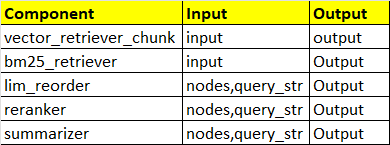

#### Draw links between modules with add_link

In [ ]:
pipe_5.add_link("input","retriever")
pipe_5.add_link("input","bm25")
pipe_5.add_link("retriever","longcontext",dest_key="nodes")
pipe_5.add_link("bm25","longcontext",dest_key="nodes")
pipe_5.add_link("input","longcontext",dest_key='query_str')
pipe_5.add_link("longcontext","reranker",dest_key="nodes")
pipe_5.add_link("input","reranker",dest_key="query_str")
pipe_5.add_link("reranker","summarizer",dest_key="nodes")
pipe_5.add_link("input","summarizer",dest_key="query_str")

#### Visualize the graph created using networkx to store the graph representation

In [ ]:
## create graph
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(pipe_5.dag)
net.save_graph("rag_dag5.html")
#

HTML(filename="rag_dag5.html")

In [ ]:
output = pipe_5.run(question="What is the purpose of using options by startups?")

> Running module input with input: 
question: What is the purpose of using options by startups?

> Running module retriever with input: 
input: What is the purpose of using options by startups?

> Running module bm25 with input: 
input: What is the purpose of using options by startups?

> Running module longcontext with input: 
query_str: What is the purpose of using options by startups?
nodes: [NodeWithScore(node=IndexNode(id_='673ff081-6622-49f3-ab23-c76ceb8792ef', embedding=None, metadata={'window': '•Why do options have intrinsic value?   –A effective form of equity ownership   –A locked...

> Running module reranker with input: 
query_str: What is the purpose of using options by startups?
nodes: [NodeWithScore(node=IndexNode(id_='673ff081-6622-49f3-ab23-c76ceb8792ef', embedding=None, metadata={'window': '•Why do options have intrinsic value?   –A effective form of equity ownership   –A locked...

> Running module summarizer with input: 
query_str: What is the purpose of using opti

Llama.generate: prefix-match hit


In [ ]:
print(str(output))

 Based on the provided information, startups use options as a way to align employees with the company's goal of achieving a "big exit." Options serve as incentives for employees in high-risk/high-reward enterprises where traditional compensation packages may not be feasible.


In [ ]:
output.metadata

{'673ff081-6622-49f3-ab23-c76ceb8792ef': {'window': '•Why do options have intrinsic value?   –A effective form of equity ownership   –A locked -in price for shares   •How do startups use options?   –To bring in founding team members  who are not co -founders  ',
  'original_text': '•How do startups use options?  ',
  'page_label': '5',
  'file_name': 'Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_path': '/content/Data/esops.pdf/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf',
  'file_type': 'application/pdf',
  'file_size': 724217,
  'creation_date': '2024-02-04',
  'last_modified_date': '2018-08-29',
  'last_accessed_date': '2024-02-04'},
 'a7026325-5afd-484c-aea2-35a06e7c954b': {'window': '–As high -risk/high -reward enterprises, startups use options to align  employee compensation with the risk -prone mentality of the  business   –Startups seeking to achieve a “big exit” use options to align all  employees to drive toward this desired outcome',
  'original_t